<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/vector_stores/FirestoreVectorStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1

The proposed method starts with preprocessing the input signals. This step includes three main steps:
* (1) Converting to mono-channel
* (2) Converting signal frequency
* (3) Signal normalization

The purpose of the pre-processing step is to remove redundant data from the audio signal, convert all signals into a standard intermediate form and prepare them for use in the next steps. For this purpose, the processes of audio signal normalization, audio signal sampling, and transformation of two-channel signals into mono-channel vector form are used. In this way, at the beginning of the pre-processing step, the two-channel nature of the input audio signal is checked. If the signal is two (or more)-channel, we convert it to a mono-channel signal. Since audio signals are recorded in different conditions and by different devices; Therefore, the frequency of some input signals may be different from other signals. For this reason, in the second step of the pre-processing phase, all the vectors of the input signal are converted to the same frequency of 16 kHz. At the end of the pre-processing step, the signal vector is converted into a vector with zero mean and unit variance, so that the special conditions of a signal (high or low volume) are eliminated as much as possible. 


In [2]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
import sys
import warnings

import soundfile as sf

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
EMODB = "/Users/huangjuhua/文档文稿/NYU/Time_Series/EMODB/"

## Create emodb_features.csv 
This code processes audio files from the **EMODB (Emotional Speech Database)** to create a structured CSV file containing metadata about each audio file. It traverses the directory containing the EMODB dataset, identifies `.wav` files, and extracts metadata such as the speaker's gender (determined by a mapping of speaker IDs) and the emotion conveyed in the speech (determined by an emotion code in the filename). 

The script constructs a list of dictionaries, where each dictionary represents an audio file and includes the gender, emotion label, file path, and data source. This information is then converted into a Pandas DataFrame and saved as a CSV file named `emodb_features.csv`. The CSV serves as a feature extraction summary, which can be used for further analysis or modeling in tasks such as emotion recognition from speech.

In [ ]:
# Define mappings for emotions and genders
emotion_mapping = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

speaker_gender_mapping = {
    '03': 'male',
    '08': 'female',
    '09': 'female',
    '10': 'male',
    '11': 'male',
    '12': 'male',
    '13': 'female',
    '14': 'female',
    '15': 'male',
    '16': 'female'
}

# Base directory of EMODB
base_dir = EMODB

# List to store data for the CSV
data = []

# Traverse through all subdirectories and files in EMODB
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".wav"):
            # Extract details from the filename
            speaker_id = file[:2]  # First two positions are the speaker ID
            emotion_code = file[5]  # Sixth position is the emotion code
            
            # Get gender and emotion label
            gender = speaker_gender_mapping.get(speaker_id, "unknown")
            emotion_label = emotion_mapping.get(emotion_code, "unknown")
            
            # Construct the full path
            file_path = os.path.join(base_dir, file)
            
            # Add the data to the list
            data.append({
                "gender": gender,
                "emotion_label": emotion_label,
                "path": file_path,
                "source": "EMODB"
            })

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Save to a CSV file
csv_path = "emodb_features.csv"
df.to_csv(csv_path, index=False)

print(f"Features extracted and saved to {csv_path}")


Features extracted and saved to emodb_features.csv


In [28]:
import pandas as pd

# Load the CSV file
csv_path = "emodb_features.csv"

df = pd.read_csv(csv_path)

df.head()



,gender,emotion_label,path,source
0,female,boredom,/Users/huangjuhua/文档文稿/NYU/Time_Series/EMODB/1...,EMODB
1,female,anger,/Users/huangjuhua/文档文稿/NYU/Time_Series/EMODB/1...,EMODB
2,male,fear,/Users/huangjuhua/文档文稿/NYU/Time_Series/EMODB/1...,EMODB
3,female,disgust,/Users/huangjuhua/文档文稿/NYU/Time_Series/EMODB/1...,EMODB
4,female,anger,/Users/huangjuhua/文档文稿/NYU/Time_Series/EMODB/1...,EMODB


## 1. Check mono-channel

To determine whether an audio signal is mono-channel or multi-channel, you can check the shape of the data array returned by the audio loading function. Here's how:

### Checking Channel Information with Librosa
When you load audio using `librosa.load`, it automatically converts audio into a mono-channel signal by default. If you want to check whether the original signal is mono or multi-channel before conversion, you'll need to use a library like `scipy` or `soundfile` instead.

### Key Differences Between Mono and Multi-Channel:
- **Mono**: A single channel of audio, typically played equally on all speakers.
- **Stereo**: Two channels (left and right) for spatial sound.

By identifying the shape of the audio data, you can determine whether you need to down-mix the signal to mono in your preprocessing step. Let me know if you'd like further clarification!


In [29]:
import librosa

# Load the audio file without converting to mono
fname = EMODB + '03a01Fa.wav'  
data, samplerate = librosa.load(file_path, sr=None, mono=False)

# Check the shape of the data
if len(data.shape) == 1:
    print("The signal is mono-channel.")
else:
    print(f"The signal is multi-channel with {data.shape[0]} channels.")


The signal is mono-channel.


# 2. Converting signal frequency & (3) Signal normalization

根据 EmoDB Dataset 的描述，所有矢量已经是 16 kHz 频率。只需要 Signal normalization

## 2.1 Show one example

<Figure size 1500x500 with 0 Axes>

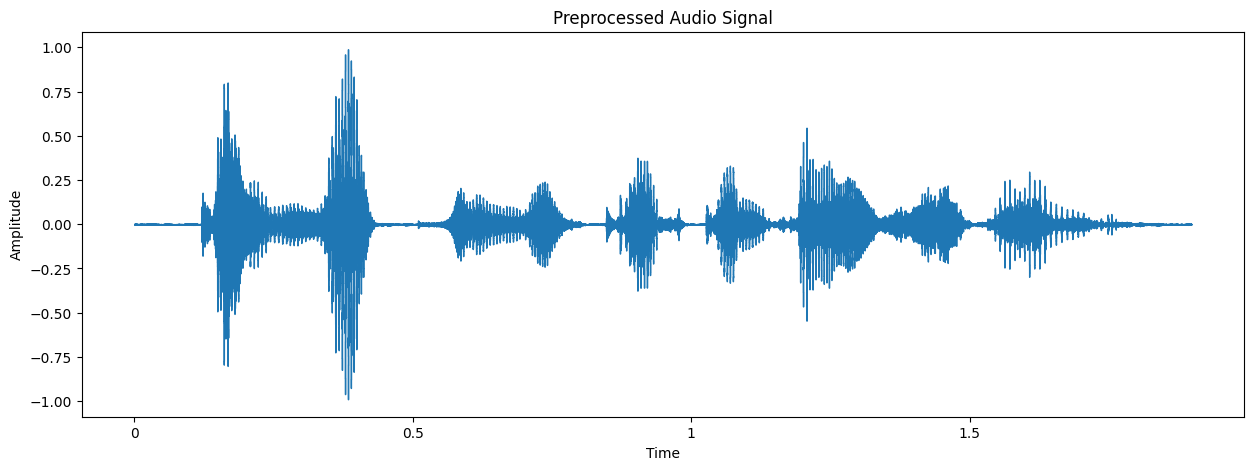

In [ ]:
# Lets play a example
fname = EMODB + '03a01Fa.wav'  
data, sampling_rate = librosa.load(fname)


plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("Preprocessed Audio Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
# Lets play the audio 
ipd.Audio(fname)

# 2.2 Signal normalization

In [13]:
def preprocess_audio_from_csv(csv_file, output_folder, target_sampling_rate=16000):
    """
    Preprocess audio files listed in a CSV file and save them to a specific folder.

    Parameters:
        csv_file (str): Path to the CSV file containing 'path' and 'source' columns.
        output_folder (str): Folder to save the preprocessed audio files.
        target_sampling_rate (int): Target frequency for resampling audio.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Filter rows where 'source' == 'EMODB'
    emodb_files = df[df['source'] == 'EMODB']['path']

    for file_path in emodb_files:
        try:
            # Step 1: Load the audio file
            data, sampling_rate = librosa.load(file_path)


            # Step 3: Normalize the signal (zero mean, unit variance)
            data = librosa.util.normalize(data)


            # Save the preprocessed audio file to the output folder with the same name
            output_file = os.path.join(output_folder, os.path.basename(file_path))
            sf.write(output_file, data, samplerate=target_sampling_rate)

            print(f"Processed and saved: {output_file}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Example usage
csv_file = 'emodb_features.csv'  # Path to your CSV file
output_folder = 'EMODB_preprocessed'  # Folder to save preprocessed files
preprocess_audio_from_csv(csv_file, output_folder)


Processed and saved: EMODB_preprocessed/16a02Lb.wav
Processed and saved: EMODB_preprocessed/14a07Wc.wav
Processed and saved: EMODB_preprocessed/10a07Ad.wav
Processed and saved: EMODB_preprocessed/13a05Ea.wav
Processed and saved: EMODB_preprocessed/14a05Wa.wav
Processed and saved: EMODB_preprocessed/14a07Na.wav
Processed and saved: EMODB_preprocessed/15a05Wa.wav
Processed and saved: EMODB_preprocessed/16b10Wb.wav
Processed and saved: EMODB_preprocessed/09a01Nb.wav
Processed and saved: EMODB_preprocessed/16a01Fc.wav
Processed and saved: EMODB_preprocessed/14a04Ed.wav
Processed and saved: EMODB_preprocessed/11a01Ab.wav
Processed and saved: EMODB_preprocessed/09b02Na.wav
Processed and saved: EMODB_preprocessed/03a05Nd.wav
Processed and saved: EMODB_preprocessed/10a01Ac.wav
Processed and saved: EMODB_preprocessed/16a04Ab.wav
Processed and saved: EMODB_preprocessed/15b02Nd.wav
Processed and saved: EMODB_preprocessed/16b09Wb.wav
Processed and saved: EMODB_preprocessed/11a01Ld.wav
Processed an

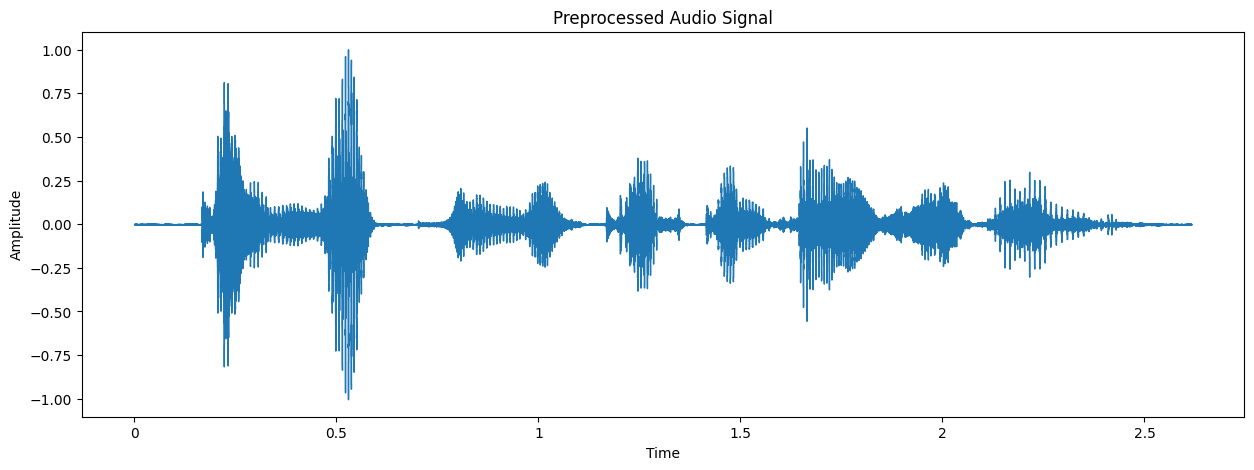

In [14]:
EMODB_preprocessed = "/Users/huangjuhua/文档文稿/NYU/Time_Series/EMODB_preprocessed/"
fname = EMODB_preprocessed + '03a01Fa.wav'  
data, sampling_rate = librosa.load(fname)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("Preprocessed Audio Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
# Lets play the audio 
ipd.Audio(fname)